In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
import torchvision
from torch.optim import Adam
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, confusion_matrix, ConfusionMatrixDisplay
import sys

In [2]:
# Connect to the GPU if one exists.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using: ", device)
torch.cuda.empty_cache()

Using:  cuda


In [3]:
train_img_data = np.load(r"C:\Users\kaanan\Desktop\Noses\train_images.npy", allow_pickle = True)
train_bb_data = np.load(r"C:\Users\kaanan\Desktop\Noses\train_bb_data.npy", allow_pickle = True)
val_img_data  = np.load(r"C:\Users\kaanan\Desktop\Noses\val_images.npy", allow_pickle = True)
val_bb_data = np.load(r"C:\Users\kaanan\Desktop\Noses\val_bb_data.npy", allow_pickle = True)

In [4]:
label_1_img = []
label_1 = []
label_0_img = []
label_0 = []
threshold = .3
for x in range(len(train_bb_data)):
  if train_bb_data[x] is not None:
    percent = float(max(train_bb_data[x]["percent_seal"]))
    if percent > threshold:
      label_1_img.append(train_img_data[x])
      label_1.append((1))
    else:
      label_0_img.append(train_img_data[x])
      label_0.append((0))
  else:
    label_0_img.append(train_img_data[x])
    label_0.append((0))

val_label = []
for x in range(len(val_bb_data)):
    if val_bb_data[x] is not None:
      percent = float(max(val_bb_data[x]["percent_seal"]))
      if percent > threshold:
        val_label.append(1)
      else:
        val_label.append(0)
    else:
      val_label.append(0)
val_label = np.array(val_label)

In [5]:
#Add mirror images and horizontal flip

new_label_1_img = []
new_label_1 = []
for img in label_1_img:
    new_label_1_img.append(img)
    new_label_1.append(1)
    new_label_1_img.append(np.fliplr(img))
    new_label_1.append(1)
    new_label_1_img.append(np.flipud(img))
    new_label_1.append(1)

In [6]:
total_labels = np.array(new_label_1 + label_0)
total_images = np.array(new_label_1_img + label_0_img)
trans = transforms.Compose([transforms.ToTensor()])

In [13]:
class SealDataset(Dataset):
    def __init__(self, images, labels, transform=transforms.Compose([transforms.ToTensor()])):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        self.length = len(self.labels)
        return self.length

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if label == 0:
            ret_label = torch.FloatTensor([1, 0])
        else:
            ret_label = torch.FloatTensor([0, 1])
        return self.transform(image), ret_label

In [14]:
total_labels = torch.tensor(total_labels, dtype=torch.long)
val_label = torch.tensor(val_label, dtype=torch.long)
train_data = SealDataset(total_images, total_labels)
valid_data = SealDataset(val_img_data, val_label)
train_loader = DataLoader(dataset = train_data, batch_size=10, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=50, shuffle=True)

C:\Users\kaanan\AppData\Local\Temp\ipykernel_16116\3139409286.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_labels = torch.tensor(total_labels, dtype=torch.long)
C:\Users\kaanan\AppData\Local\Temp\ipykernel_16116\3139409286.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_label = torch.tensor(val_label, dtype=torch.long)


In [15]:
efficientnet = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
efficientnet.classifier[1] = nn.Linear(in_features=1280, out_features=2)
efficientnet = efficientnet.to(device)

In [16]:
weights = class_weight.compute_class_weight("balanced", classes = np.unique(np.array(new_label_1 + label_0)), y = np.array(new_label_1 + label_0))
class_weights = torch.FloatTensor(weights).to(device)
opt = Adam(efficientnet.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [17]:
def train_model(model, epochs, opt, loss, train, device):
    model.train()
    N = len(train.dataset)
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total_seen = 0
        loop = tqdm(train)
        for data, label in loop:
            # Run model
            data = data.to(device)
            label = label.type(torch.FloatTensor).to(device)
            opt.zero_grad()
            yhat = model(data).type(torch.FloatTensor).to(device)
            loss = loss_fn(yhat, label)
            # Meta Data
            total_loss += abs(loss.item())
            for i in range(len(yhat)):
                if yhat[i][1] > .5 and label[i][1] == 1:
                    correct += 1
                elif yhat[i][0] > .5 and label[i][0] == 1:
                    correct += 1
                total_seen += 1
            # Back prop
            loss.backward()
            opt.step()
            loop.set_description("Epoch: {}      Accuracy: {}      MAE: {}      ".format(epoch, round(correct/total_seen, 4), round(total_loss/total_seen, 4)))
            loop.refresh()
        print(f"Epoch:{epoch + 1} MAE:{total_loss / N} Accuracy: {correct / N}")

def validate_data(model, valid, device):
    model.eval()
    total_yhat = np.array([])
    total_labels = np.array([])
    for data, label in tqdm(valid):
        data = data.to(device)
        yhat = model(data).cpu().detach().numpy()
        total_yhat = np.concatenate((total_yhat, np.argmax(yhat, axis = 1)))
        total_labels = np.concatenate((total_labels, np.argmax(label.detach().numpy(), axis = 1)))
    cm_train = confusion_matrix(total_labels, total_yhat)
    ConfusionMatrixDisplay(confusion_matrix=cm_train).plot()
    tn = cm_train[0][0]
    tp = cm_train[1][1]
    fn = cm_train[1][0]
    fp = cm_train[0][1]

    precision = tp / (fp + tp)
    recall = tp / (fn + tp)
    print("Accuracy:", (tn + tp) / (tn + tp + fn + fp))
    print("Precision:", precision)
    print("Recall:", recall)

In [18]:
def train_model_with_val(model, epochs, opt, loss, train, val, device):
    model.train()
    N = len(train.dataset)
    train_accuracy = []
    val_accuracy = []
    training_MAE = []
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total_seen = 0
        loop = tqdm(train)
        model.train()
        for data, label in loop:
            # Run model
            data = data.to(device)
            label = label.type(torch.FloatTensor).to(device)
            opt.zero_grad()
            yhat = model(data).type(torch.FloatTensor).to(device)
            loss = loss_fn(yhat, label)
            # Meta Data
            total_loss += abs(loss.item())
            for i in range(len(yhat)):
                if yhat[i][1] > .5 and label[i][1] == 1:
                    correct += 1
                elif yhat[i][0] > .5 and label[i][0] == 1:
                    correct += 1
                total_seen += 1
            # Back prop
            loss.backward()
            opt.step()
            loop.set_description("Epoch: {}      Accuracy: {}      MAE: {}   ".format(epoch, round(correct/total_seen, 4), round(total_loss/total_seen, 4)))
            loop.refresh()
        print(f"Epoch:{epoch + 1} MAE:{total_loss / N} Accuracy: {correct / N}")
        train_accuracy.append(correct / N)
        training_MAE.append(total_loss/total_seen)
        model.eval()
        total_yhat = np.array([])
        total_labels = np.array([])
        for data, label in tqdm(val):
            data = data.to(device)
            yhat = model(data).cpu().detach().numpy()
            total_yhat = np.concatenate((total_yhat, np.argmax(yhat, axis = 1)))
            total_labels = np.concatenate((total_labels, np.argmax(label.detach().numpy(), axis = 1)))
        val_correct = 0
        for i in range(len(total_yhat)):
            if total_yhat[i] == total_labels[i]:
                val_correct += 1
        val_accuracy.append(val_correct / len(total_yhat))
        print(f"Epoch:{epoch + 1} Validation Accuracy: {val_correct / len(total_yhat)}")
    return train_accuracy, val_accuracy, training_MAE
        

In [19]:
train_accuracy, val_accuracy, mae = train_model_with_val(efficientnet, 5, opt, loss_fn, train_loader, valid_loader, device)

  0%|          | 0/9621 [00:00<?, ?it/s]

Epoch:1 MAE:0.02332953857901689 Accuracy: 0.8388109344143021


  0%|          | 0/414 [00:00<?, ?it/s]

Epoch:1 Validation Accuracy: 0.9371069182389937


  0%|          | 0/9621 [00:00<?, ?it/s]

Epoch:2 MAE:0.01644393205919067 Accuracy: 0.8921110071718117


  0%|          | 0/414 [00:00<?, ?it/s]

Epoch:2 Validation Accuracy: 0.9145137880986938


  0%|          | 0/9621 [00:00<?, ?it/s]

Epoch:3 MAE:0.012635229762298287 Accuracy: 0.9220974950628833


  0%|          | 0/414 [00:00<?, ?it/s]

Epoch:3 Validation Accuracy: 0.9500241896468311


  0%|          | 0/9621 [00:00<?, ?it/s]

Epoch:4 MAE:0.009853575621914013 Accuracy: 0.9397879638291238


  0%|          | 0/414 [00:00<?, ?it/s]

Epoch:4 Validation Accuracy: 0.9519109820996613


  0%|          | 0/9621 [00:00<?, ?it/s]

Epoch:5 MAE:0.008200732728806115 Accuracy: 0.9494958943976718


  0%|          | 0/414 [00:00<?, ?it/s]

Epoch:5 Validation Accuracy: 0.9578616352201258


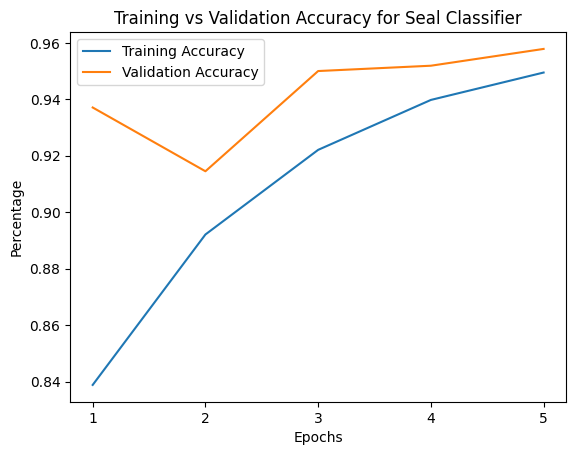

In [21]:
epochs = [x+1 for x in range(5)]
plt.plot(epochs, train_accuracy, label = "Training Accuracy")
plt.plot(epochs, val_accuracy, label = "Validation Accuracy")
plt.xticks(ticks=epochs)
#plt.plot(epochs, mae, label = "Training Mean Absolute Error")
plt.xlabel('Epochs') 
plt.ylabel('Percentage') 
plt.title("Training vs Validation Accuracy for Seal Classifier")
plt.legend()
plt.show()

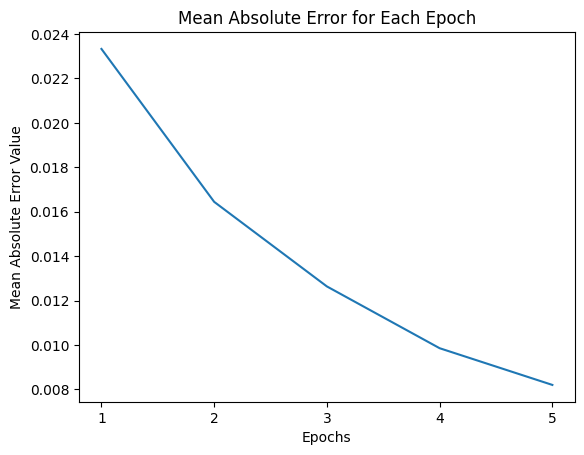

In [22]:
plt.plot(epochs, mae)
plt.xticks(ticks=epochs)
plt.xlabel('Epochs') 
plt.ylabel('Mean Absolute Error Value') 
plt.title("Mean Absolute Error for Each Epoch")
plt.show()

  0%|          | 0/414 [00:00<?, ?it/s]

Accuracy: 0.9578616352201258
Precision: 0.7868679775280899
Recall: 0.8946107784431138


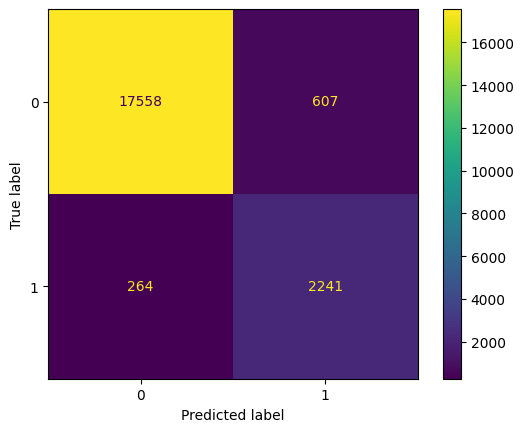

In [24]:
validate_data(efficientnet, valid_loader, device)

In [25]:
torch.save(efficientnet.state_dict(), r"C:\Users\kaanan\Desktop\Noses/ImageClassifierPytorch8")

In [23]:
# Retrain old moddel
resnet = resnet152(weights=ResNet152_Weights.DEFAULT)
for p in resnet.parameters():
            p.requires_grad = False
my_model = NeuralNetwork()
resnet.fc = my_model
model = resnet.to(device)
model.load_state_dict(torch.load(r"C:\Users\kaanan\Desktop\Noses/ImageClassifierPytorch4"))

<All keys matched successfully>

In [30]:
weights = class_weight.compute_class_weight("balanced", classes = np.unique(np.array(new_label_1 + label_0)), y = np.array(new_label_1 + label_0))
class_weights = torch.FloatTensor(weights).to(device)
opt = Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
train_model(model, 1, opt, loss_fn, train_loader, device)

  0%|          | 0/9621 [00:00<?, ?it/s]

C:\Users\kaanan\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:1 MAE:0.042580341287758776 Accuracy: 0.8861344974534872


  0%|          | 0/138 [00:00<?, ?it/s]

Accuracy: 0.9302370585389453
Precision: 0.6654217242452537
Recall: 0.8534930139720559


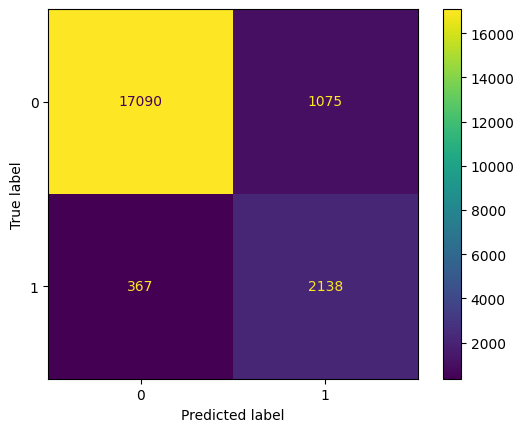

In [17]:
validate_data(model, valid_loader, device)

In [29]:
torch.save(model.state_dict(), r"C:\Users\kaanan\Desktop\Noses/ImageClassifierPytorch6")